# Figure 4
___

Number of DTU switches between regions
---

In [8]:
library(SummarizedExperiment)
library(tidyverse)

library(ggplot2)


In [9]:
parent <- '/prj/Florian_Leuschner_spatial/analysis/Nanopore/' 

# we use the OFDR for both
ofdr.gene <- 0.05
ofdr.trx <- 0.05

# define the order to fill the upper triangle
contrasts <- c('IvsBZ', 'IvsRZ1', 'IvsRZ2', 'BZvsRZ1', 'BZvsRZ2', 'RZ1vsRZ2')
row_idx <- c(1,1,1,2,2,3)
col_idx <- c(2,3,4,3,4,4)

# data - change path, this is provided as supplement
sumExp <- readRDS(file.path(parent, 'Nanopore', 'dtu', 'results', 'satuRn_scnast_fact_regs.RDS'))


In [11]:
mat <- matrix(NA, nrow=4, ncol=4)
for (idx in seq_along(contrasts)) {
    df <- rowData(sumExp)[[paste("fitDTUResult", contrasts[idx], sep="_")]]
    num_switches <- df %>% filter(padj_gene < ofdr.gene & padj_transcript < ofdr.trx) %>%
                            tibble::rownames_to_column(var="transcript_id") %>% 
                            tidyr::separate(transcript_id, c("transcript", "gene"), sep=":") %>%
                            group_by(gene) %>%
                                mutate(sign = sign(estimates) ) %>%
                                mutate(switch = replace(sign, n_distinct(sign)==1, 0) ) %>% 
                                ungroup() %>%
                            filter(switch!=0) %>%
                            summarize(switches=n_distinct(gene)) %>% 
                            pull(1) 
    mat[row_idx[idx], col_idx[idx]] <- num_switches
}
colnames(mat) <- c('I', 'BZ', 'RZ1', 'RZ2')
rownames(mat) <- c('I', 'BZ', 'RZ1', 'RZ2')
mat <- reshape2::melt(mat, na.rm = TRUE)

In [12]:
mat$Var1 <- factor(mat$Var1, levels=rev(levels(mat$Var1)))
mat$Var2 <- factor(mat$Var2, levels=rev(levels(mat$Var2)))

In [14]:
g <- ggplot(data = mat, aes(Var2, Var1, fill = value)) +
 geom_tile(color = "white")+
 scale_fill_gradientn(colors = hcl.colors(50, "RdBu"), limit = c(0,max(mat$value))) +
 scale_x_discrete(position = "top") +
 geom_text(aes(Var2, Var1, label = value), color = case_when(
        mat$value == max(mat$value) ~ "white",
        mat$value < max(mat$value) ~ "black"), size = 10) +
 theme(
  axis.title.x = element_blank(),
  axis.title.y = element_blank(),
  axis.text = element_text(size = 20, face='bold'),
  panel.grid.major = element_blank(),
  panel.border = element_blank(),
  panel.background = element_blank(),
  axis.ticks = element_blank(),
  legend.position ="none")

filen <- file.path(parent, 'ScNaST', 'paper', 'figures', '4', fsep=.Platform$file.sep)
filen <- file.path(filen, 'num_switches.pdf')
ggsave(filen, width=8, height=8, dpi=1200)


In [ ]:
# write supp. table
library(openxlsx)

info <- data.frame(name=c('estimates', 'se', 'df', 't', 'pval', 'FDR', 'empirical_pval', 'empirical_FDR', 'padj_gene', 'padj_transcript'), 
                   desc=c('The estimated log-odds ratios (log base e). In the most simple case, an estimate of +1 would mean that the odds of picking that transcript from the pool of transcripts within its corresponding gene is exp(1) = 2.72 times larger in condition B than in condition A.',
                         'The standard error on this estimate.',
                         'The posterior degrees of freedom for the test statistic.',
                         'The student t-test statistic, computed with a Wald test given estimates and se.',
                         'The "raw" p-value given t and df.',
                         'The false discovery rate, computed using the multiple testing correction of Benjamini and Hochberg on pval.',
                         'An "empirical" p-value that is computed by estimating the null distribution of the test statistic empirically.',
                         'The false discovery rate, computed using the multiple testing correction of Benjamini and Hochberg on pval_empirical.',
                         'stageR FDR-adjusted screening p-values (gene level). Only genes passing the screening stage are considered for analysis.',
                         'stageR FWER-adjusted confirmation p-values (transcript level). Transcript passing the confirmation stage are DTU.'))

wb <- createWorkbook()
addWorksheet(wb, sheetName='description')
writeDataTable(wb, sheet=1, x=info)
for (idx in seq_along(contrasts)) {
    df <- rowData(sumExp)[[paste("fitDTUResult", contrasts[idx], sep="_")]]
    df <- df %>% filter(padj_gene < alpha.gene & padj_transcript < alpha.trx) %>%
                            tibble::rownames_to_column(var="transcript_id") %>% 
                            tidyr::separate(transcript_id, c("transcript", "gene"), sep=":") %>%
                            group_by(gene) %>%
                                mutate(sign = sign(estimates) ) %>%
                                mutate(switch = replace(sign, n_distinct(sign)==1, 0) ) %>% 
                                ungroup() %>%
                            filter(switch!=0)
    df <- df[,1:12]
    df <- df[order(df$padj_gene, df$padj_transcript),]
    addWorksheet(wb, sheetName=contrasts[idx])
    writeDataTable(wb, sheet=idx+1, x=df)
}

filen <- file.path(parent, 'ScNaST', 'paper', 'supplement', 'Nanopore', 'isoform_switching_genes.xlsx', fsep=.Platform$file.sep)
saveWorkbook(wb, filen, overwrite = TRUE)

Dot plot of top DTU switches
---

Python!

In [17]:
import os

import scanpy as sc

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=120, facecolor='white', frameon=False)

import anndata

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import colors

# from Scrublet
def darken_cmap(cmap, scale_factor):
    cdat = np.zeros((cmap.N, 4))
    for ii in range(cdat.shape[0]):
        curcol = cmap(ii)
        cdat[ii,0] = curcol[0] * scale_factor
        cdat[ii,1] = curcol[1] * scale_factor
        cdat[ii,2] = curcol[2] * scale_factor
        cdat[ii,3] = 1
    cmap = cmap.from_list(cmap.N, cdat)
    return cmap
cmaps = darken_cmap(plt.cm.Reds_r, 0.9)

bone_reversed = plt.cm.get_cmap('bone_r')

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.20.3 scipy==1.6.3 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.1


In [8]:
parent = '/prj/Florian_Leuschner_spatial/analysis/Nanopore' 
outname = 'scnast' 
filen = os.path.join(parent, 'Nanopore', 'data', f"anatomical_regions_and_cell_props_{outname}.h5ad")
adata = sc.read_h5ad(filen)

raw = adata.raw.to_adata()
adata

AnnData object with n_obs × n_vars = 7616 × 12590
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'n_transcripts', 'pct_mt', 'library_id', 'anatomical_region', 'nanopore_only', 'C_scANVI'
    var: 'feature_types', 'genome', 'qry_id', 'ref_id', 'qry_gene_id', 'ref_gene_id', 'ref_gene_name', 'class_code', 'n_cells-A', 'n_cells-B', 'n_cells-C', 'n_cells-D'
    uns: 'C_scANVI_colors', 'anatomical_region_colors', 'hvg', 'library_id_colors', 'neighbors', 'spatial', 'umap'
    obsm: 'X_scANVI', 'X_umap', 'deconvolution', 'spatial'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [9]:
# DTU results: top 5 DTU transcripts across all contrasts, if gene is also a SVG (SPARK), grouped by gene

colord = {'Actc1': ['ENSMUST00000090269:Actc1', 'MSTRG.10093.1:Actc1'], # omit 2 class code = x for visualisation
         'Pdlim5': ['ENSMUST00000029941:Pdlim5', 'ENSMUST00000170361:Pdlim5'],
         'mt-Nd5': ['MSTRG.18712.1:mt-Nd5', 'MSTRG.18712.3:mt-Nd5', 'MSTRG.18712.6:mt-Nd5', 'MSTRG.18712.8:mt-Nd5'],
         'Tpm1': ['ENSMUST00000113707:Tpm1', 'ENSMUST00000113705:Tpm1', 'ENSMUST00000113690:Tpm1', 'ENSMUST00000050905:Tpm1', 'MSTRG.18175.15:Tpm1', 'ENSMUST00000113685:Tpm1'],
         'Ankrd1': ['ENSMUST00000236579:Ankrd1', 'ENSMUST00000235941:Ankrd1', 'ENSMUST00000237142:Ankrd1'],
         'Sparc': ['MSTRG.2466.1:Sparc', 'ENSMUST00000018737:Sparc'],
         'Crip2': ['MSTRG.4244.1:Crip2', 'ENSMUST00000084882:Crip2'],
         'Clu': ['ENSMUST00000022616:Clu', 'MSTRG.5594.2:Clu'],
         'Tmsb4x': ['ENSMUST00000112172:Tmsb4x', 'ENSMUST00000112176:Tmsb4x'],
         'Apoe': ['ENSMUST00000174064:Apoe', 'ENSMUST00000173739:Apoe', 'ENSMUST00000174355:Apoe', 'ENSMUST00000003066:Apoe'],
         'Myl2': ['MSTRG.13783.2:Myl2', 'MSTRG.13783.5:Myl2', 'MSTRG.13783.8:Myl2', 'ENSMUST00000111751:Myl2', 'ENSMUST00000152744:Myl2', 'ENSMUST00000014080:Myl2']}


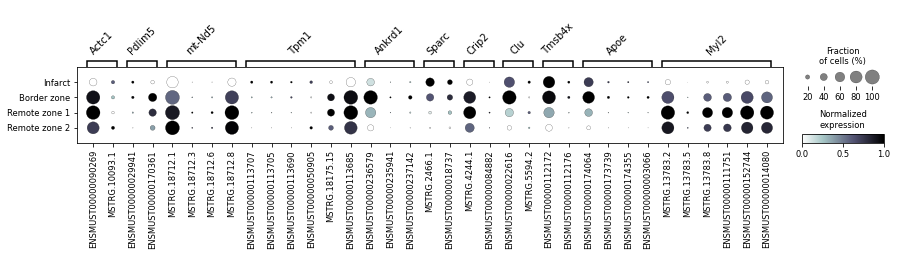

In [10]:
ax = sc.pl.dotplot(adata, colord, groupby='anatomical_region', use_raw=True, standard_scale='var', categories_order=['Infarct', 'Border zone', 'Remote zone 1', 'Remote zone 2'],
              cmap=bone_reversed, dendrogram=False, swap_axes=False, var_group_rotation=45, colorbar_title='Normalized\nexpression', size_title='Fraction\nof cells (%)',
              show=False)
ticklabels = [raw.var.loc[label.get_text()]['qry_id'] for label in ax['mainplot_ax'].get_xticklabels()]
_ = ax['mainplot_ax'].set_xticklabels(ticklabels)

for ext in ['pdf', 'svg']:
    filen = os.path.join(parent, 'ScNaST', 'paper', 'figures', '4', f'dotplot_topDTU.{ext}')
    plt.savefig(filen, dpi=800, bbox_inches='tight')


In [ ]:
# Choose Pdlim5 as example, with C

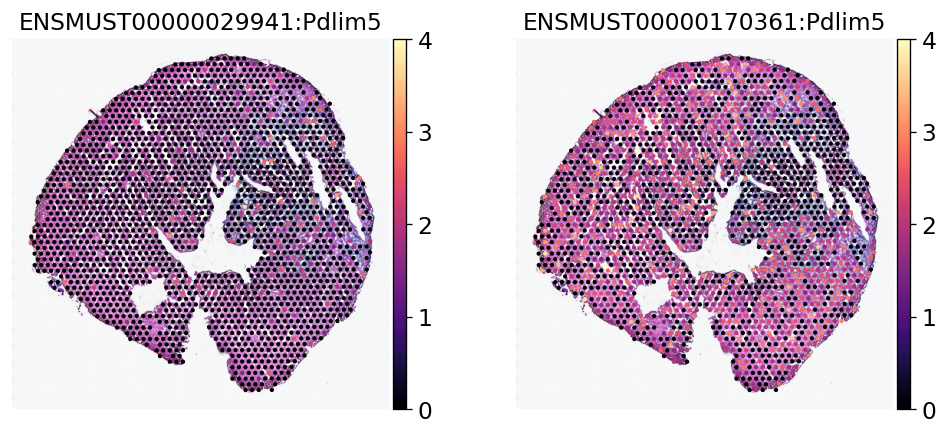

In [40]:
library = 'D'
ad = adata[adata.obs.library_id == library, :].copy()
ax = sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=library,
        vmax=4,
        cmap='magma',
        color=colord['Pdlim5'],
        legend_loc=None,
        show=False,
        use_raw=True
    )

for ext in ['pdf', 'svg']:
    filen = os.path.join(parent, 'ScNaST', 'paper', 'figures', '4', f'Pdlim5.{ext}')
    plt.savefig(filen, bbox_inches = "tight")